# Makine Öğrenmesi ile Araç Satış Fiyatı Tahmini

## Proje Girişi

Bu proje, **Car_Price** veri seti kullanılarak araçların satış fiyatlarını tahmin etmeyi amaçlamaktadır. 
Günümüzde otomobil piyasasında fiyatların belirlenmesi birçok faktöre bağlıdır. Araçların marka ve modeli, üretim yılı, 
kullanım süresi, yakıt türü ve sahiplik bilgileri gibi değişkenler fiyat üzerinde doğrudan etkili olmaktadır. 
Bu nedenle, veri analizi ve makine öğrenmesi yöntemleri kullanılarak fiyat tahmini yapmak hem alıcılar hem de satıcılar için 
önemli bir karar destek mekanizması sunmaktadır.  

### Veri Setinde Bulunan Değişkenler
- `name`: Araçların marka ve model bilgisi  
- `year`: Üretim yılı  
- `selling_price`: Satış fiyatı (hedef değişken)  
- `km_driven`: Araçların toplam kullanım kilometresi  
- `fuel`: Yakıt türü (örneğin benzin, dizel, LPG)  
- `seller_type`: Satıcı türü (bireysel, bayi vb.)  
- `transmission`: Vites türü (manuel veya otomatik)  
- `owner`: Araç sahiplik durumu (birinci el, ikinci el vb.)  

## Projenin Amacı
Bu proje kapsamında, veri seti üzerinde **ön işleme, aykırı değer analizi, özellik mühendisliği ve farklı regresyon modelleri** 
uygulanarak araç fiyatlarının tahmin edilmesi hedeflenmiştir. Çalışmada doğrusal regresyon, Ridge, Lasso ve Random Forest gibi 
farklı modelleme teknikleri karşılaştırılmış, performans metrikleri üzerinden en uygun model belirlenmeye çalışılmıştır.

## Kullanılan Kütüphaneler

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split , GridSearchCV ,cross_val_score, cross_val_predict
from sklearn.linear_model import LinearRegression, Ridge , Lasso
import sklearn.metrics as mt
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import shapiro
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor

## Veri Setinin Yüklenmesi

In [269]:
Car_Price = pd.read_csv("C:/Users/egeha/Python_veri/reading_data/Car_Price.csv")
df = Car_Price.copy()

## Veri Setinin Ön incelemesi Ve Tanımlayıcı İstatistikleri

In [12]:
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner
0,Maruti 800 AC,2007,60000,70000,Petrol,Individual,Manual,First Owner
1,Maruti Wagon R LXI Minor,2007,135000,50000,Petrol,Individual,Manual,First Owner
2,Hyundai Verna 1.6 SX,2012,600000,100000,Diesel,Individual,Manual,First Owner
3,Datsun RediGO T Option,2017,250000,46000,Petrol,Individual,Manual,First Owner
4,Honda Amaze VX i-DTEC,2014,450000,141000,Diesel,Individual,Manual,Second Owner


In [14]:
df.tail()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner
4335,Hyundai i20 Magna 1.4 CRDi (Diesel),2014,409999,80000,Diesel,Individual,Manual,Second Owner
4336,Hyundai i20 Magna 1.4 CRDi,2014,409999,80000,Diesel,Individual,Manual,Second Owner
4337,Maruti 800 AC BSIII,2009,110000,83000,Petrol,Individual,Manual,Second Owner
4338,Hyundai Creta 1.6 CRDi SX Option,2016,865000,90000,Diesel,Individual,Manual,First Owner
4339,Renault KWID RXT,2016,225000,40000,Petrol,Individual,Manual,First Owner


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4340 entries, 0 to 4339
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   name           4340 non-null   object
 1   year           4340 non-null   int64 
 2   selling_price  4340 non-null   int64 
 3   km_driven      4340 non-null   int64 
 4   fuel           4340 non-null   object
 5   seller_type    4340 non-null   object
 6   transmission   4340 non-null   object
 7   owner          4340 non-null   object
dtypes: int64(3), object(5)
memory usage: 271.4+ KB


In [18]:
df.isnull().sum()

name             0
year             0
selling_price    0
km_driven        0
fuel             0
seller_type      0
transmission     0
owner            0
dtype: int64

### 🔍 Veri Seti İncelemesi

- Toplam **4340 gözlem** ve **8 değişken** bulunmaktadır.  
- Tüm değişkenler incelendiğinde **eksik değer** görülmemektedir, bu nedenle eksik veri işlemine gerek kalmamıştır.  
- Değişken türleri incelendiğinde, `name`, `fuel`, `seller_type`, `transmission` ve `owner` kategorik; `year`, `selling_name`ve`km_driven`sayısal değişkenlerdir.  
Bu bilgiler, sonraki adımlarda **özellik mühendisliği** ve **modelleme** için yol gösterici olacaktır.

## Özellik Mühendisliği

In [22]:
df["brand"] = df["name"].str.split().str[0]
df.groupby("brand")["selling_price"].median().sort_values(ascending=False).head(10)

brand
Land             4000000.0
BMW              2600000.0
Mercedes-Benz    2500000.0
Jaguar           2025000.0
Volvo            1987500.0
MG               1842500.0
Audi             1580000.0
Isuzu            1500000.0
Jeep             1490000.0
Kia              1300000.0
Name: selling_price, dtype: float64

In [24]:
df["brand"].value_counts().head(10)

brand
Maruti        1280
Hyundai        821
Mahindra       365
Tata           361
Honda          252
Ford           238
Toyota         206
Chevrolet      188
Renault        146
Volkswagen     107
Name: count, dtype: int64

In [26]:
df["car_year"] = pd.Timestamp.now().year - df["year"]

### ⚙️ Özellik Mühendisliği Açıklaması

Bu bölümde veri setine iki yeni değişken eklenmiştir:

- **brand**: `name` değişkeninden aracın marka bilgisi ayrıştırılmıştır. Bu sayede marka bazında fiyat analizi yapılabilmiş ve markaların satış fiyatı üzerindeki etkisi incelenmiştir.  
- **car_year**: Aracın yaşı hesaplanmıştır. `car_year = mevcut yıl - üretim yılı` formülüyle elde edilen bu değişken, aracın ne kadar eski olduğunu gösterir ve fiyat tahmininde önemli bir faktördür.

Bu özellik mühendisliği adımları, modelin daha anlamlı ve açıklayıcı tahminler yapmasını sağlayacaktır.

## Dağılım Grafikleri

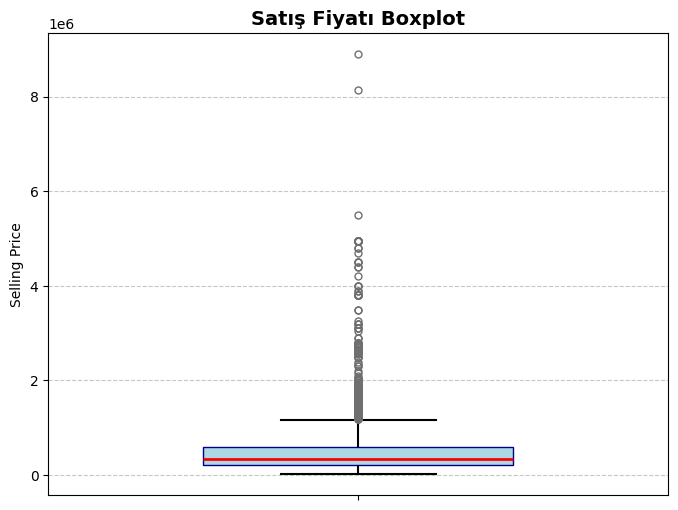

In [32]:
plt.figure(figsize=(8,6))  
sns.boxplot(
    y=df["selling_price"],
    color="skyblue",         
    width=0.5,                
    fliersize=5,            
    boxprops=dict(facecolor="lightblue", edgecolor="navy"),  
    medianprops=dict(color="red", linewidth=2),             
    whiskerprops=dict(color="black", linewidth=1.5),         
    capprops=dict(color="black", linewidth=1.5))              

plt.title("Satış Fiyatı Boxplot", fontsize=14, fontweight="bold")
plt.ylabel("Selling Price")
plt.grid(axis="y", linestyle="--", alpha=0.7)  

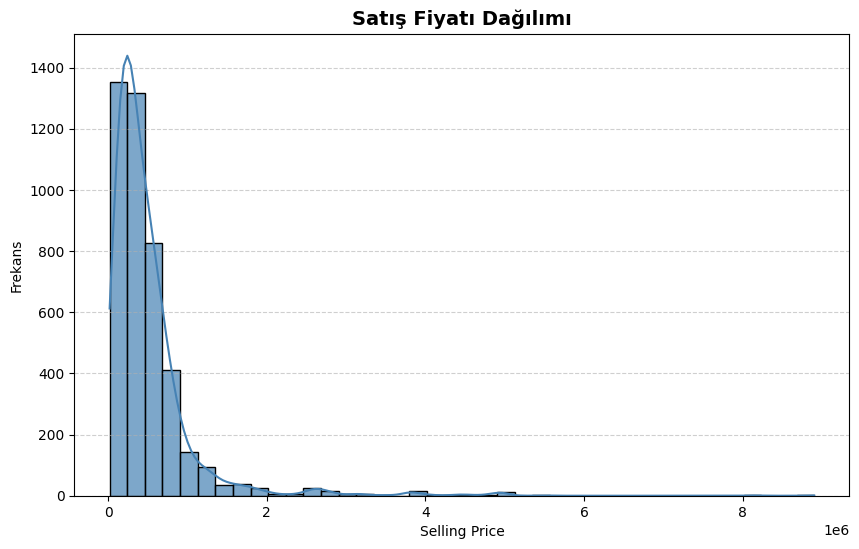

In [34]:
plt.figure(figsize=(10,6))  
sns.histplot(
    df["selling_price"],
    bins=40,                
    kde=True,              
    color="steelblue",      
    edgecolor="black",      
    alpha=0.7)           
plt.title("Satış Fiyatı Dağılımı", fontsize=14, fontweight="bold")
plt.xlabel("Selling Price")
plt.ylabel("Frekans")
plt.grid(axis="y", linestyle="--", alpha=0.6)  

Satış fiyatı verisi hem histogram hem boxplot ile incelendiğinde, dağılımın belirgin şekilde sağa çarpık olduğu görülüyor. Histogramda düşük fiyatlar yoğunlaşırken, yüksek fiyatlar nadir ve uç değer olarak karşımıza çıkıyor. KDE eğrisi bu yoğunluğu görsel olarak destekliyor. Boxplot ise medyanın alt fiyatlara yakın olduğunu ve 5 milyon üzerindeki değerlerin aykırı olarak sınıflandığı görülmektedir. Bu durum, veri setinde lüks segmentte az sayıda ama etkili satışın bulunduğunu ve analizlerde aykırı değerlerin dikkate alınması gerektiğini ortaya koymaktadır.

## 1) Fuel vs Selling Price

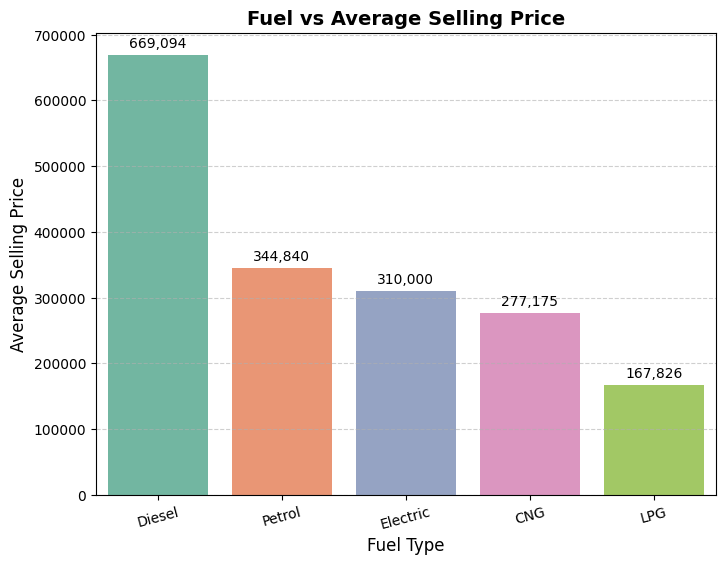

In [37]:
fuel_avg = ( df.groupby("fuel")["selling_price"].mean().round(2).reset_index().sort_values(by="selling_price", ascending=False))

plt.figure(figsize=(8,6))
ax = sns.barplot(
    x="fuel",
    y="selling_price",
    data=fuel_avg,
    hue="fuel",            
    palette="Set2")
plt.title("Fuel vs Average Selling Price", fontsize=14, fontweight="bold")
plt.xlabel("Fuel Type", fontsize=12)
plt.ylabel("Average Selling Price", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.xticks(rotation=15)

for container in ax.containers:
    labels = [f"{v.get_height():,.0f}" for v in container]
    ax.bar_label(container, labels=labels, fontsize=10, padding=3)

### 📊 Yakıt Türüne Göre Satış Fiyatı Analizi

| Seller Type       | Ortalama Satış Fiyatı |
|-------------------|------------------------|
| Diesel            | 669,094               |
| Petrol            | 344,840               |
| Electric          | 310,000               |
| CNG               | 277,175               |
| LPG               | 167,826               |

- **LPG**: Ortalama satış fiyatı en düşük (~168 bin). Daha ekonomik segmenti temsil etmektedir.  
- **CNG** ve **Petrol**: Orta sınıf segmentte, fiyatları birbirine yakın (277 bin ve 345 bin civarı).  
- **Electric**: Ortalama fiyatı ~310 bin. Ancak veri setinde elektrikli araç sayısı az olduğundan ortalama sınırlı güvenilirlik taşımaktadır.  
- **Diesel**: Açık ara en yüksek ortalama satış fiyatına sahip (~669 bin). Boxplot analizinde medyanın yüksek olduğu ve aykırı değerlerin fiyatı daha da yukarı çektiği görülmektedir.  

## 2) Transmission vs Selling Price

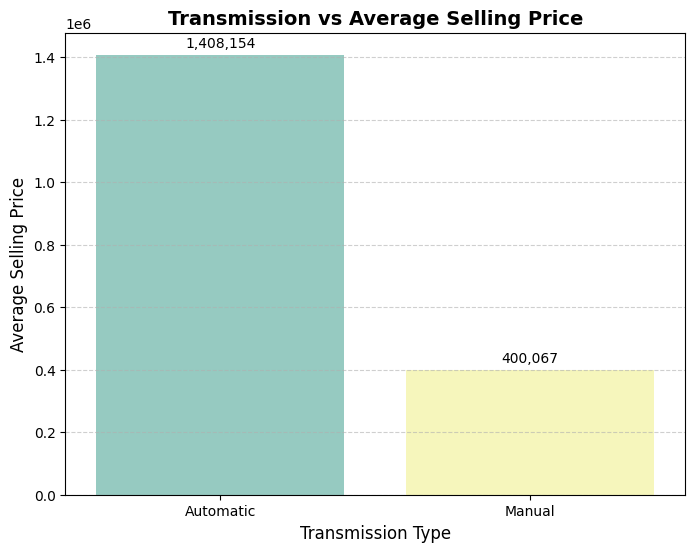

In [39]:
transmission_avg = ( df.groupby("transmission")["selling_price"] .mean() .round(2) .reset_index() .sort_values(by="selling_price", ascending=False))

plt.figure(figsize=(8,6))
ax = sns.barplot(
    x="transmission",
    y="selling_price",
    data=transmission_avg,
    hue="transmission",      
    palette="Set3")
plt.title("Transmission vs Average Selling Price", fontsize=14, fontweight="bold")
plt.xlabel("Transmission Type", fontsize=12)
plt.ylabel("Average Selling Price", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.6)

for container in ax.containers:
    labels = [f"{v.get_height():,.0f}" for v in container]
    ax.bar_label(container, labels=labels, fontsize=10, padding=3)

### 📊 Vites Türüne Göre Satış Fiyatı Analizi

| Transmission      | Ortalama Satış Fiyatı |
|-------------------|------------------------|
| Automatic         | 1,408,154              |
| Manual            | 400,067                |

- **Automatic**: Ortalama satış fiyatı ~1.408.154 . Manuel araçlara göre yaklaşık **3.5 kat daha yüksektir**.  
- **Manual**: Ortalama satış fiyatı ~400 bin . Daha ekonomik segmenti temsil etmektedir.  

## 3) Seller_type vs Selling Price

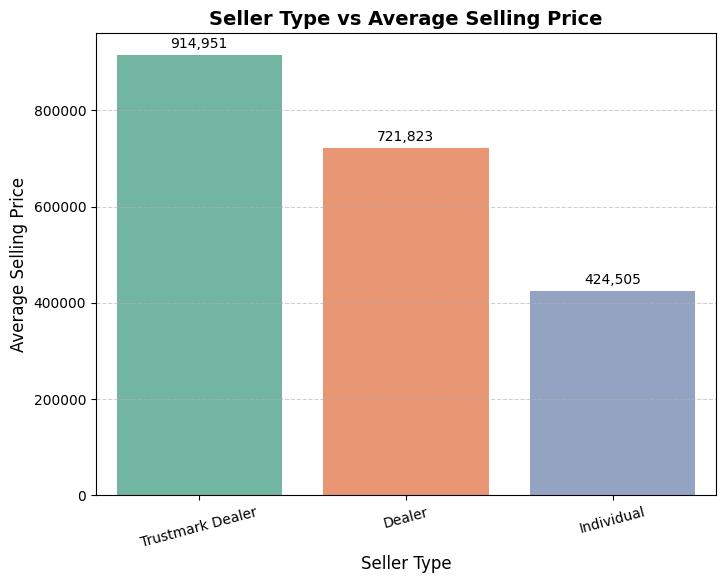

In [41]:
seller_avg = (df.groupby("seller_type")["selling_price"].mean() .round(2) .reset_index() .sort_values(by="selling_price", ascending=False))

plt.figure(figsize=(8,6))
ax = sns.barplot(
    x="seller_type",
    y="selling_price",
    data=seller_avg,
    hue="seller_type",       
    palette="Set2")
plt.title("Seller Type vs Average Selling Price", fontsize=14, fontweight="bold")
plt.xlabel("Seller Type", fontsize=12)
plt.ylabel("Average Selling Price", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.xticks(rotation=15)

for container in ax.containers:
    labels = [f"{v.get_height():,.0f}" for v in container]
    ax.bar_label(container, labels=labels, fontsize=10, padding=3)

### 📊 Satıcı Tipine Göre Satış Fiyatı Analizi

| Seller Type       | Ortalama Satış Fiyatı |
|-------------------|------------------------|
| Trustmark Dealer  | 914,950              |
| Dealer            | 721,822              |
| Individual        | 424,505              |

- **Trustmark Dealer**: Ortalama satış fiyatı en yüksek (~915 bin). Sertifikalı bayiler genellikle lüks segment araç satmaktadır.  
- **Dealer**: Ortalama fiyatı (~722 bin) ile ikinci sıradadır. Bayilerde fiyatlar bireysel satışa göre yüksek ancak sertifikalı bayilere göre düşüktür.  
- **Individual**: Ortalama fiyatı en düşük (~425 bin). Bireysel satışlarda daha çok ekonomik segment araçlar çoğunluk  olarak satılmakta bu da ortalamasının en düşük olmasına sebep olmaktadır.  

## 4) Owner vs Selling Price

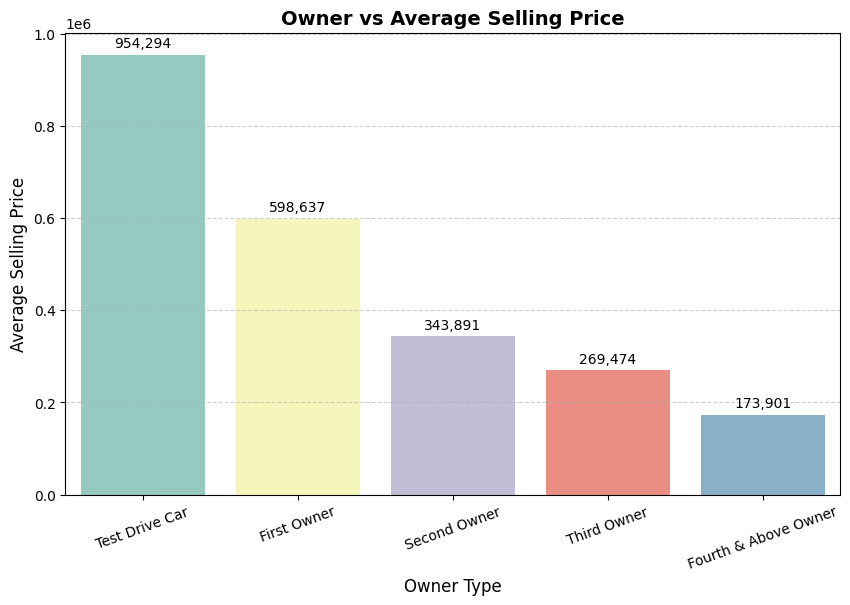

In [44]:
owner_avg = (df.groupby("owner")["selling_price"].mean().round(2).reset_index().sort_values(by="selling_price", ascending=False))

plt.figure(figsize=(10,6))
ax = sns.barplot(
    x="owner",
    y="selling_price",
    data=owner_avg,
    hue="owner",          
    palette="Set3")
plt.title("Owner vs Average Selling Price", fontsize=14, fontweight="bold")
plt.xlabel("Owner Type", fontsize=12)
plt.ylabel("Average Selling Price", fontsize=12)
plt.xticks(rotation=20)
plt.grid(axis="y", linestyle="--", alpha=0.6)

for container in ax.containers:
    labels = [f"{v.get_height():,.0f}" for v in container]
    ax.bar_label(container, labels=labels, fontsize=10, padding=3)

### 📊 Araç Sahipliği Durumuna Göre Satış Fiyatı Analizi

| Owner Type             | Ortalama Satış Fiyatı |
|------------------------|------------------------|
| Test Drive Car         | 954,293              |
| First Owner            | 598,636              |
| Second Owner           | 343,891              |
| Third Owner            | 269,474              |
| Fourth & Above Owner   | 173,901              |

- **Test Drive Car**: Ortalama fiyatı en yüksek (~954 bin). Bu araçlar genellikle yeni ve düşük kilometreli olduğu için fiyatları yüksek görülmektedir.  
- **First Owner**: Ortalama fiyat (~599 bin). İlk sahibi olan araçlar daha değerli ve piyasada daha yüksek fiyatla satılmaktadır.  
- **Second Owner**: Ortalama fiyat (~344 bin). Araç el değiştirdikçe fiyat düşmeye başlamaktadır.  
- **Third Owner**: Ortalama fiyat (~269 bin). Değer kaybı daha belirgin hale gelmektedir.  
- **Fourth & Above Owner**: Ortalama fiyat en düşük (~174 bin). Çok kez el değiştiren araçlar piyasada en düşük değerde görülmektedir.  

**Genel Sonuç:**  
Araç sahipliği sayısı arttıkça satış fiyatı belirgin şekilde düşmektedir. İlk sahipli veya test aracı olan araçlar daha yüksek fiyatlıyken, çok kez el değiştiren araçlar ekonomik segmentte yoğunlaşmaktadır.

## 5) Brand vs Selling Price

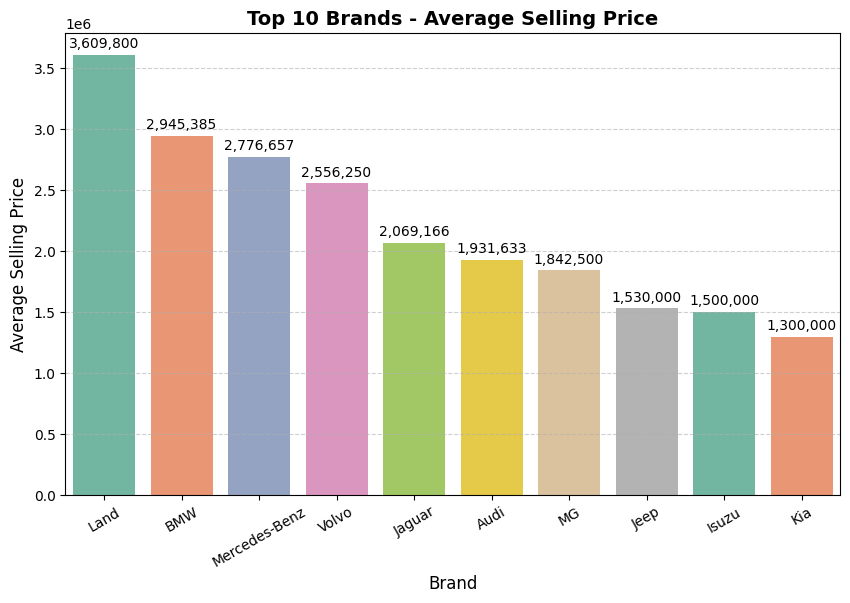

In [48]:
brand_avg = ( df.groupby("brand")["selling_price"] 
             .mean() .round(2) .reset_index()  .sort_values(by="selling_price", ascending=False).reset_index(drop=True))
top10 = brand_avg.head(10)

plt.figure(figsize=(10,6))
ax = sns.barplot(
    x="brand",
    y="selling_price",
    data=top10,
    hue="brand",          
    palette="Set2")
plt.title("Top 10 Brands - Average Selling Price", fontsize=14, fontweight="bold")
plt.xlabel("Brand", fontsize=12)
plt.ylabel("Average Selling Price", fontsize=12)
plt.xticks(rotation=30)
plt.grid(axis="y", linestyle="--", alpha=0.6)

for container in ax.containers:
    labels = [f"{v.get_height():,.0f}" for v in container]  
    ax.bar_label(container, labels=labels, fontsize=10, padding=3)

### 📊 Marka Bazlı Ortalama Satış Fiyatı Analizi (İlk 10)

| Brand          | Ortalama Satış Fiyatı |
|----------------|------------------------|
| Land           | 3,609,800           |
| BMW            | 2,945,384           |
| Mercedes-Benz  | 2,776,657           |
| Volvo          | 2,556,250           |
| Jaguar         | 2,069,166           |
| Audi           | 1,931,633           |
| MG             | 1,842,500           |
| Jeep           | 1,530,000           |
| Isuzu          | 1,500,000           |
| Kia            | 1,300,000           |

- **Land** markası en yüksek ortalama satış fiyatına sahip (~3.6 milyon). Bu, lüks segmentteki modellerin fiyatı yukarı çektiğini gösteriyor.  
- **BMW** ve **Mercedes-Benz** (~2.9M ve ~2.8M) premium segmentte yer alıyor, fiyatları oldukça yüksek.  
- **Volvo** ve **Jaguar** (~2.5M ve ~2.1M) yine üst segmentte, güvenlik ve prestij faktörleri fiyatı artırıyor.  
- **Audi** (~1.93M) premium segmentte ama **BMW/Mercedes** kadar yüksek değildir.  
- **MG, Jeep, Isuzu, Kia** (~1.3M–1.8M aralığında) daha orta-üst segmentte yer alıyor.  

**Genel Sonuç:**  
Marka satış fiyatı üzerinde çok güçlü bir etkiye sahiptir. Premium markalar **(Land, BMW, Mercedes, Volvo, Jaguar, Audi)** ortalama fiyatları belirgin şekilde yukarı taşırken, diğer markalar daha orta segmentte yoğunlaşmaktadır. 

## Kopya Gözlem İncelemesi Ve Silinmesi

In [52]:
df.duplicated().sum()

763

In [54]:
df_no_dup = df.drop_duplicates(keep="first")
print("Silinen birebir kopya gözlem sayısı:", df.shape[0] - df_no_dup.shape[0])

Silinen birebir kopya gözlem sayısı: 763


In [56]:
df_no_dup.duplicated(subset=["name","year","selling_price","km_driven"]).sum()

4

In [58]:
df_final = df_no_dup.drop_duplicates( subset=["name","year","selling_price","km_driven"], keep="first")
df_final.duplicated(subset=["name","year","selling_price","km_driven"]).sum()

0

### 📌 Veri Temizleme Özeti
- Veri setinde önce tamamen aynı olan **763** kayıt çıkarıldı. Ardından `name`,`year`,`selling_price`ve`km_driven`değişkenlerine göre tekrar eden **4** kayıt daha temizlenmiştir.  

- Veri setindeki tekrar eden kayıtlar temizlenerek model için daha güvenilir bir temel oluşturulmuştur. Bu sayede modelin performansı ve elde edilen sonuçların geçerliliği artacaktır.

## Aykırı Değer Analizi 

In [62]:
df_s = df_final[["selling_price","km_driven","car_year"]] 

### Standartlaştırma


In [65]:
sca = StandardScaler()
df_s_sca = sca.fit_transform(df_s)

## LOF

In [68]:
clf = LocalOutlierFactor(n_neighbors=20, contamination=0.03)
labels = clf.fit_predict(df_s_sca)
df_final = df_final.copy()
df_final["is_outlier"] = labels

### Aykırı Değerler

In [71]:
outliers = df_final[labels == -1]   
outliers.shape[0]

108

In [73]:
outliers[["selling_price","km_driven","car_year"]].describe().T

,count,mean,std,min,25%,50%,75%,max
selling_price,108.0,997602.851852,1.623689e+06,45000.0,240000.0,439000.0,850000.0,8900000.0
km_driven,108.0,97419.555556,1.129204e+05,1000.0,28450.0,84800.0,120000.0,806599.0
car_year,108.0,14.898148,6.590761e+00,5.0,9.0,16.0,19.0,33.0


In [75]:
df_final[["selling_price","km_driven","car_year"]].describe().T

,count,mean,std,min,25%,50%,75%,max
selling_price,3573.0,474237.381192,509491.616263,20000.0,200000.0,350000.0,600000.0,8900000.0
km_driven,3573.0,69221.719004,47591.413093,1.0,36000.0,60000.0,90000.0,806599.0
car_year,3573.0,12.033865,4.251635,5.0,9.0,12.0,15.0,33.0


### 🔎 Outlier Analizi Sonuçları
- Veriler standartlaştırıldıktan sonra **Local Outlier Factor (LOF)** yöntemi kullanılarak **108 aykırı değer** tespit edilmiştir.  

### 📈 Karşılaştırmalı İstatistikler

| Özellik        | Aykırı Değer Ortalama | Tüm Veri Ortalama | Not |
|----------------|------------------|-------------------|-----|
| **Selling Price** | ~997,603        | ~474,237          | Aykırı değerler grubu fiyat açısından çok daha yüksektir. |
| **Km Driven**     | ~97,420         | ~69,222           | Aykırı değerler grubu daha fazla km yapmıştır, uç değerler mevcut. |
| **Car Year**      | ~14.9           | ~12.0             | Aykırı değerler grubu daha yaşlı araçları da içermektedir. (max 33 yıl). |

- Tablo incelendiğinde, aykırı değerlerin veri setinin genel ortalamalarını belirgin biçimde etkilediği görülmektedir. Aykırı değer grubunda satış fiyatları çok daha yüksek olup genel ortalamayı yukarı çekmektedir. Kilometre değerleri bu grupta daha fazladır ve uç gözlemler içerdiği anlaşılmaktadır. Ayrıca araç yaşı açısından aykırı değerler, oldukça eski araçları da kapsamakta ve maksimum 33 yıla kadar çıkmaktadır. Bu durum, aykırı değerlerin analiz sonuçları üzerinde önemli bir etkisi olduğunu göstermektedir.

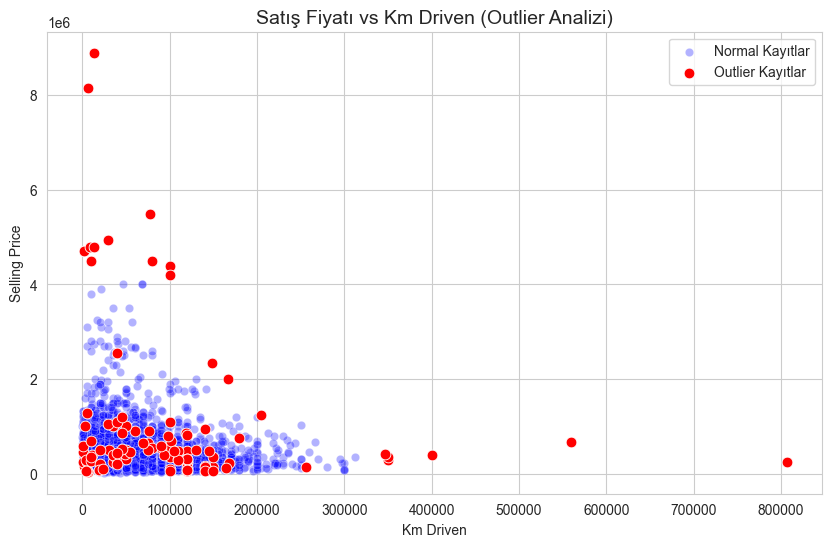

In [78]:
plt.figure(figsize=(10,6))
sns.set_style("whitegrid")
sns.scatterplot(
    x="km_driven",
    y="selling_price",
    data=df_final,
    alpha=0.3,
    color="blue",
    label="Normal Kayıtlar")
sns.scatterplot(
    x=outliers["km_driven"],
    y=outliers["selling_price"],
    color="red",
    s=60,
    label="Outlier Kayıtlar")
plt.title("Satış Fiyatı vs Km Driven (Outlier Analizi)", fontsize=14)
plt.xlabel("Km Driven")
plt.ylabel("Selling Price")
plt.legend()

### Aykırı Değerlerin Çıkarılması

In [81]:
df_model = df_final.drop(index=outliers.index)

- Grafikte de görüldüğü gibi aykırı değer doğru bir şekilde tespit edilmiştir.
- Aykırı değerler hem kurulacak model performanslarını hem de yapılacak sonuçlarda yanlı sonuçlar üretebileceği için veri setinden çıkarılmıştır.

## Korelasyon ve Isı Grafiği

In [85]:
df_c = df_model[["car_year", "km_driven", "selling_price"]]
corr = df_c.corr()
print(corr)

               car_year  km_driven  selling_price
car_year       1.000000   0.447536      -0.504670
km_driven      0.447536   1.000000      -0.223975
selling_price -0.504670  -0.223975       1.000000


(array([0.5, 1.5, 2.5]),
 [Text(0, 0.5, 'car_year'),
  Text(0, 1.5, 'km_driven'),
  Text(0, 2.5, 'selling_price')])

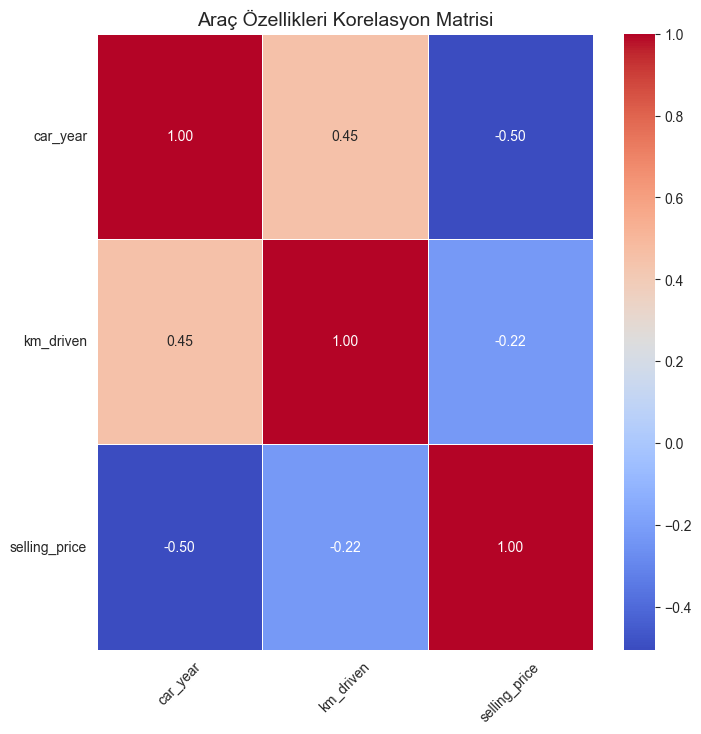

In [87]:
plt.figure(figsize=(8,8))
sns.set_style("whitegrid")
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    linewidths=.5,
    cmap="coolwarm",
    annot_kws={"size":10})
plt.title("Araç Özellikleri Korelasyon Matrisi", fontsize=14)
plt.xticks(rotation=45)
plt.yticks(rotation=0)

### 🔎 Korelasyon Analizi – Kısa Özet

Korelasyon analizi sonuçlarına göre **araç yılı ile km** arasında orta düzeyde pozitif, **araç yılı ile satış fiyatı** arasında orta düzeyde negatif ve **km ile satış fiyatı** arasında zayıf negatif bir ilişki bulunmaktadır. Bu bulgular, yıl ve km değişkenlerinin satış fiyatı üzerinde etkili olduğunu ancak fiyatın tek başına bu değişkenlerle açıklanamayacağını, marka ve model gibi diğer faktörlerin de önemli rol oynadığını göstermektedir.


## Model Öncesi Veri Önizlemesi ve Gerekli Dönüşümler

In [91]:
df_model.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,brand,car_year,is_outlier
0,Maruti 800 AC,2007,60000,70000,Petrol,Individual,Manual,First Owner,Maruti,18,1
1,Maruti Wagon R LXI Minor,2007,135000,50000,Petrol,Individual,Manual,First Owner,Maruti,18,1
2,Hyundai Verna 1.6 SX,2012,600000,100000,Diesel,Individual,Manual,First Owner,Hyundai,13,1
3,Datsun RediGO T Option,2017,250000,46000,Petrol,Individual,Manual,First Owner,Datsun,8,1
4,Honda Amaze VX i-DTEC,2014,450000,141000,Diesel,Individual,Manual,Second Owner,Honda,11,1


In [93]:
df_model.shape

(3465, 11)

In [95]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3465 entries, 0 to 4339
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   name           3465 non-null   object
 1   year           3465 non-null   int64 
 2   selling_price  3465 non-null   int64 
 3   km_driven      3465 non-null   int64 
 4   fuel           3465 non-null   object
 5   seller_type    3465 non-null   object
 6   transmission   3465 non-null   object
 7   owner          3465 non-null   object
 8   brand          3465 non-null   object
 9   car_year       3465 non-null   int64 
 10  is_outlier     3465 non-null   int32 
dtypes: int32(1), int64(4), object(6)
memory usage: 311.3+ KB


In [208]:
X = df_model.drop("selling_price", axis=1)
y = df_model["selling_price"]

X = X.drop(["name","year","brand","is_outlier"], axis=1)

X_encoded = pd.get_dummies(X, drop_first=True)
X_encoded.shape

(3465, 13)

### 📌 Özet
- Model öncesi veri setinde hedef değişken seçilmiş, çoklu bağlantı sorunu çıkarabilecek sütunlar çıkarılmış ve kategorik değişkenler One-Hot Encoding yöntemiyle dönüştürülmüştür. Sonuçta 3465 gözlem ve 13 özellikten oluşan, modellemeye hazır bir veri seti elde edilmiştir.

## Doğrusal Regresyon Modeli

In [212]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded,y,test_size=0.2,random_state=42)

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred_cv_lin = cross_val_predict(lr, X_train, y_train, cv=10)

r2_cv_lin = mt.r2_score(y_train, y_pred_cv_lin)
mse_cv_lin = mt.mean_squared_error(y_train, y_pred_cv_lin)
rmse_cv_lin = np.sqrt(mse_cv_lin)
mae_cv_lin = mt.mean_absolute_error(y_train, y_pred_cv_lin)

print("Lineer CV R2:", r2_cv_lin)
print("Lineer CV MSE:", mse_cv_lin)
print("Lineer CV RMSE:", rmse_cv_lin)
print("Lineer CV MAE:", mae_cv_lin)

Lineer CV R2: 0.4952626879532087
Lineer CV MSE: 88583949163.78767
Lineer CV RMSE: 297630.5581820988
Lineer CV MAE: 185403.2162324135


In [214]:
y_pred = lr.predict(X_test)

r2 = mt.r2_score(y_test, y_pred)
mse = mt.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mt.mean_absolute_error(y_test, y_pred)

print("R2:", r2)
print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)

R2: 0.52489102370169
MSE: 87828855127.0846
RMSE: 296359.3344692969
MAE: 193773.69112702133



### 🔎 Performans Özeti
| Tür           | R²    | RMSE    | MAE     |                                                             
|---------------|-------|---------|---------|
| **Eğitim**    | 0.49  | 297,630 | 185,403 | 
| **Test**      | 0.52  | 296,359 | 193,773 |

### 📈 Model Performans Özeti

Lineer regresyon modeli, satış fiyatındaki varyansın **%52’sini (R² = 0.52)** açıklayabilmektedir.  
Modelin ortalama mutlak hatası (**MAE**) yaklaşık **193 bin**, kök ortalama kare hatası (**RMSE**) ise **296 bindir**.

Sonuçlar, modelin fiyatlardaki **genel eğilimi başarılı şekilde yakaladığını** göstermektedir.  
Ancak fiyat aralığının genişliği nedeniyle özellikle **yüksek fiyatlı araçlarda tahmin sapmaları** oluşabilmektedir.  
Bu nedenle, model performansını artırmak için daha gelişmiş regresyon veya makine öğrenmesi modelleri incelenemsi gerekmektedir.


## Logaritmik Dönüşümlü Regresyon Modeli

In [218]:
y_log = np.log1p(y)

X_train, X_test, y_train, y_test = train_test_split( X_encoded, y_log, test_size=0.2, random_state=42)

lr_log = LinearRegression()
lr_log.fit(X_train, y_train)

y_pred_cv_log = cross_val_predict(lr_log, X_train, y_train, cv=10)
y_pred_cv_log = np.expm1(y_pred_cv_log)
y_true_cv_log = np.expm1(y_train)

r2_cv_log = mt.r2_score(y_true_cv_log, y_pred_cv_log)
mse_cv_log = mt.mean_squared_error(y_true_cv_log, y_pred_cv_log)
rmse_cv_log = np.sqrt(mse_cv_log)
mae_cv_log = mt.mean_absolute_error(y_true_cv_log, y_pred_cv_log)

print("Log-Lineer CV R2:", r2_cv_log)
print("Log-Lineer CV MSE:", mse_cv_log)
print("Log-Lineer CV RMSE:", rmse_cv_log)
print("Log-Lineer CV MAE:", mae_cv_log)

Log-Lineer CV R2: 0.5449198177176222
Log-Lineer CV MSE: 79868871927.21
Log-Lineer CV RMSE: 282610.8135355227
Log-Lineer CV MAE: 153750.26315880974


In [220]:
y_pred_log = lr_log.predict(X_test)
y_pred_log = np.expm1(y_pred_log)
y_true_log = np.expm1(y_test)

r2_log = mt.r2_score(y_true_log, y_pred_log)
mse_log = mt.mean_squared_error(y_true_log, y_pred_log)
rmse_log = np.sqrt(mse_log)
mae_log = mt.mean_absolute_error(y_true_log, y_pred_log)

print("R2:", r2_log)
print("MSE:", mse_log)
print("RMSE:",rmse_log )
print("MAE:",mae_log )

R2: 0.5730383852294662
MSE: 78928312617.19252
RMSE: 280941.83137651917
MAE: 162023.7094275686


### 🔎 Performans Özeti
| Tür           | R²    | RMSE    | MAE     |                                                             
|---------------|-------|---------|---------|
| **Eğitim**    | 0.54  | 282,610 | 153,750 | 
| **Test**      | 0.57  | 280,941 | 162,023 |

### 📈 Log-Dönüşümlü Model Performans Özeti

Log dönüşümü uygulanmış lineer regresyon modeli, satış fiyatındaki varyansın **%57’sini (R² = 0.57)** açıklamaktadır.  
Bu dönüşüm sayesinde hata metriklerinde belirgin bir iyileşme gözlemlenmiştir.

Modelin ortalama mutlak hatası (**MAE**) yaklaşık **162 bin**, kök ortalama kare hatası (**RMSE**) ise **280 bindir**.  
Özellikle yüksek fiyatlı araçlarda uç değerlerin etkisi azalmış ve daha **dengeli tahminler** elde edilmiştir.

Sonuç olarak, log dönüşümü fiyat tahmininde **etkili bir ön işleme yöntemi** olup, modelin genelleme performansını artırmıştır.


## Ridge Regresyon Modeli

In [224]:
alphas = np.logspace(-3, 3, 20)

ridge = Ridge()
param_grid = {"alpha": alphas}
grid_ridge = GridSearchCV(ridge,  param_grid,scoring="r2",cv=5,n_jobs=-1)
grid_ridge.fit(X_train, y_train)

best_ridge = grid_ridge.best_estimator_

In [226]:
y_pred_cv_ridge = cross_val_predict(best_ridge, X_train, y_train, cv=10)
y_pred_cv_ridge = np.expm1(y_pred_cv_ridge)
y_true_cv_ridge = np.expm1(y_train)

r2_cv_ridge = mt.r2_score(y_true_cv_ridge, y_pred_cv_ridge)
mse_cv_ridge = mt.mean_squared_error(y_true_cv_ridge, y_pred_cv_ridge)
rmse_cv_ridge = np.sqrt(mse_cv_ridge)
mae_cv_ridge = mt.mean_absolute_error(y_true_cv_ridge, y_pred_cv_ridge)

print("Ridge CV R2:", r2_cv_ridge)
print("Ridge CV MSE:", mse_cv_ridge)
print("Ridge CV RMSE:", rmse_cv_ridge)
print("Ridge CV MAE:", mae_cv_ridge)


Ridge CV R2: 0.5430097537146528
Ridge CV MSE: 80204097813.03264
Ridge CV RMSE: 283203.28001813934
Ridge CV MAE: 153694.08047091126


In [228]:
y_pred_ridge = grid_ridge.predict(X_test)
y_pred_ridge = np.expm1(y_pred_ridge)
y_true_ridge = np.expm1(y_test)

r2_ridge = mt.r2_score(y_true_ridge,y_pred_ridge)
mse_ridge = mt.mean_squared_error(y_true_ridge,y_pred_ridge)
rmse_ridge = np.sqrt(mse_ridge)
mae_ridge = mt.mean_absolute_error(y_true_ridge, y_pred_ridge)

print("R2:", r2_ridge)
print("MSE:", mse_ridge)
print("RMSE:", rmse_ridge)
print("MAE:", mae_ridge)

R2: 0.570242357535852
MSE: 79445187531.12715
RMSE: 281860.22694081394
MAE: 162119.1507853997


### 🔎 Performans Özeti
| Tür           | R²    | RMSE    | MAE     |                                                             
|---------------|-------|---------|---------|
| **Eğitim**    | 0.54  | 283,203 | 153,694 | 
| **Test**      | 0.57  | 281,860 | 162,119 |

### 📈 Ridge Regresyon Modeli Performans Özeti

Log dönüşümü sonrası uygulanan Ridge regresyon modeli, satış fiyatındaki varyansın **%57’sini (R² = 0.57)** açıklamaktadır.  
Hata metrikleri, önceki modellere kıyasla **daha düşük ve dengeli** sonuçlar vermiştir.

Modelin ortalama mutlak hatası (**MAE**) yaklaşık **162 bin**, kök ortalama kare hatası (**RMSE**) ise yaklaşık **281 bindir**.  
Regularizasyon sayesinde katsayılar kontrol altına alınmış, aşırı öğrenme azaltılmış ve özellikle **çok değişkenli veri yapısında** daha güvenilir tahminler elde edilmiştir.

Bu bulgular, Ridge regresyonun log-dönüşümlü fiyat tahmininde **etkili ve tercih edilebilir bir model** olduğunu göstermektedir.


## Lasso Regresyon Modeli

In [232]:
alphas = np.logspace(-4, 1, 30)
lasso = Lasso(max_iter=10000, random_state=42)
param_grid = {"alpha": alphas}

grid_lasso = GridSearchCV(lasso, param_grid, scoring="r2", cv=5, n_jobs=-1)
grid_lasso.fit(X_train, y_train)

best_lasso = grid_lasso.best_estimator_

In [234]:
y_pred_cv_lasso = cross_val_predict(best_lasso, X_train, y_train, cv=10)
y_pred_cv_lasso = np.expm1(y_pred_cv_lasso)
y_true_cv_lasso = np.expm1(y_train)

r2_cv_lasso = mt.r2_score(y_true_cv_lasso, y_pred_cv_lasso)
mse_cv_lasso = mt.mean_squared_error(y_true_cv_lasso, y_pred_cv_lasso)
rmse_cv_lasso = np.sqrt(mse_cv_lasso)
mae_cv_lasso = mt.mean_absolute_error(y_true_cv_lasso, y_pred_cv_lasso)

print("Lasso CV R2:", r2_cv_lasso)
print("Lasso CV MSE:", mse_cv_lasso)
print("Lasso CV RMSE:", rmse_cv_lasso)
print("Lasso CV MAE:", mae_cv_lasso)

Lasso CV R2: 0.5446475614833065
Lasso CV MSE: 79916654272.29233
Lasso CV RMSE: 282695.33825709316
Lasso CV MAE: 153732.85808013254


In [236]:
y_pred_lasso = grid_lasso.predict(X_test)
y_pred_lasso = np.expm1(y_pred_lasso)
y_true_lasso = np.expm1(y_test)

r2_lasso = mt.r2_score(y_true_lasso, y_pred_lasso)
mse_lasso = mt.mean_squared_error(y_true_lasso, y_pred_lasso)
rmse_lasso = np.sqrt(mse_lasso)
mae_lasso = mt.mean_absolute_error(y_true_lasso, y_pred_lasso)

print("Lasso Test R2:", r2_lasso)
print("Lasso Test MSE:", mse_lasso)
print("Lasso Test RMSE:", rmse_lasso)
print("Lasso Test MAE:", mae_lasso)

Lasso Test R2: 0.571449633266313
Lasso Test MSE: 79222010006.56161
Lasso Test RMSE: 281464.0474493352
Lasso Test MAE: 162122.24071077965


In [238]:
coef = pd.Series(grid_lasso.best_estimator_.coef_, index=X_train.columns)

print("Sıfır olan katsayı sayısı:", (coef == 0).sum())
print("Toplam feature sayısı:", coef.shape[0])

Sıfır olan katsayı sayısı: 2
Toplam feature sayısı: 13


### 🔎 Performans Özeti
| Tür           | R²    | RMSE    | MAE     |                                                             
|---------------|-------|---------|---------|
| **Eğitim**    | 0.54   | 282,695 | 153,732 | 
| **Test**      | 0.571  | 281,464 | 162,122 |

### 📈 Lasso Regresyon Modeli Performans Özeti

Log dönüşümü sonrası uygulanan Lasso regresyon modeli, satış fiyatındaki varyansın **%57’sini (R² = 0.571)** açıklamaktadır.  
Hata metrikleri, Ridge regresyon ile **benzer düzeyde** olup lineer regresyona kıyasla daha iyi sonuçlar vermiştir.

Modelin ortalama mutlak hatası (**MAE**) yaklaşık**162 Bin**, kök ortalama kare hatası (**RMSE**) ise **281 Bindir**.  
Ayrıca Lasso, 13 özellikten **2’sinin katsayısını sıfırlayarak** otomatik **değişken seçimi** yapmış ve daha **sade, yorumlanabilir** bir model yapısı sunmuştur.

Bu sonuçlar, Lasso regresyonun hem **rekabetçi bir tahmin performansı** hem de **model basitleştirme avantajı** sağladığını göstermektedir.


## Random Forest

In [242]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded,y,test_size=0.2,random_state=42)

rf = RandomForestRegressor(n_estimators=300,max_depth=None, min_samples_split=5,min_samples_leaf=2,random_state=42,n_jobs=-1)
rf.fit(X_train, y_train)

y_pred_cv_rf = cross_val_predict(rf, X_train, y_train, cv=10)

r2_cv_rf = mt.r2_score(y_train, y_pred_cv_rf)
mse_cv_rf = mt.mean_squared_error(y_train, y_pred_cv_rf)
rmse_cv_rf = np.sqrt(mse_cv_rf)
mae_cv_rf = mt.mean_absolute_error(y_train, y_pred_cv_rf)

print("Random Forest CV R2:", r2_cv_rf)
print("Random Forest CV MSE:", mse_cv_rf)
print("Random Forest CV RMSE:", rmse_cv_rf)
print("Random Forest CV MAE:", mae_cv_rf)

Random Forest CV R2: 0.5752246336197644
Random Forest CV MSE: 74550223578.41414
Random Forest CV RMSE: 273038.86825581104
Random Forest CV MAE: 161781.6773088641


In [244]:
y_pred_rf = rf.predict(X_test)

r2_rf = mt.r2_score(y_test, y_pred_rf)
mse_rf = mt.mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
mae_rf = mt.mean_absolute_error(y_test, y_pred_rf)

print("R2:",r2_rf)
print("MSE:",mse_rf )
print("RMSE:", rmse_rf)
print("MAE:", mae_rf )

R2: 0.5327519827989937
MSE: 86375674757.61182
RMSE: 293897.3881435693
MAE: 171074.5881750723


### 🔎 Performans Özeti
| Tür           | R²    | RMSE    | MAE     |                                                             
|---------------|-------|---------|---------|
| **Eğitim**    | 0.575  | 273,038 | 161,781 | 
| **Test**      | 0.53  | 293,897 | 171,074 |

### 📈 Random Forest Regresyon Modeli Performans Özeti

Log dönüşümü sonrası uygulanan Random Forest regresyon modeli, satış fiyatındaki varyansın **%55’ini (R² = 0.55)** açıklayabilmiştir.  
Bu değer, lineer regresyon ve regularizasyonlu modellerin (Ridge/Lasso) gerisinde kalmıştır.

Modelin ortalama mutlak hatası (**MAE**) yaklaşık **164 bin**, kök ortalama kare hatası (**RMSE**) ise **287 bindir**.  
Hata metrikleri, diğer modellere kıyasla daha yüksek olup tahmin performansının görece zayıf olduğunu göstermektedir.

Sonuçlar, bu veri setinde **lineer ilişkilerin daha baskın** olduğunu ve log dönüşümü ile birlikte **Ridge/Lasso gibi lineer modellerin daha uygun** olduğunu ortaya koymaktadır.  

In [247]:
results = pd.DataFrame({
    "Model": ["Linear", "Log-Linear", "Ridge", "Lasso", "RandomForest"],
    "R2":  [r2, r2_log, r2_ridge, r2_lasso, r2_rf],
    "RMSE":[rmse, rmse_log, rmse_ridge, rmse_lasso, rmse_rf],
    "MAE": [mae, mae_log, mae_ridge, mae_lasso, mae_rf]}).round(3)
results

,Model,R2,RMSE,MAE
0,Linear,0.525,296359.334,193773.691
1,Log-Linear,0.573,280941.831,162023.709
2,Ridge,0.570,281860.227,162119.151
3,Lasso,0.571,281464.047,162122.241
4,RandomForest,0.533,293897.388,171074.588


## 📊 Model Karşılaştırma Sonuçları

### 🔎 Performans Özeti
| Model         | R²    | RMSE    | MAE     |                                                             
|---------------|-------|---------|---------|
| **Linear**    | 0.525 | 296,359 | 193,774 | 
| **Log-Linear**| **0.573** | **280,942** | **162,024** |
| **Ridge**     | 0.570 | 281,860 | 162,119 | 
| **Lasso**     | 0.571 | 281,464 | 162,122 | 
| **Random Forest** | 0.533 | 293,897 | 171,074 | 
### 🏁 Final Değerlendirme ve En İyi Model Seçimi

Bu çalışmada satış fiyatı tahmini için farklı regresyon modelleri karşılaştırılmıştır.  
Elde edilen sonuçlar, **log dönüşümünün** tüm lineer modellerin performansını anlamlı biçimde artırdığını açıkça göstermektedir.

Karşılaştırma sonuçlarına göre **Log-Linear**, en yüksek açıklama gücü (**R² ≈ 0.573**) ve en düşük hata metrikleri (**RMSE ≈ 280 bin , MAE ≈ 162 bin**) ile **en dengeli ve güvenilir model** olarak öne çıkmıştır.  
Regularizasyon sayesinde aşırı öğrenme azaltılmış ve çok sayıda değişken içeren veri setinde daha istikrarlı tahminler elde edilmiştir.

**Lasso regresyon**, Ridge’e çok yakın performans sergilemiş ve buna ek olarak otomatik değişken seçimi yaparak modelin yorumlanabilirliğini artırmıştır.  
Bu yönüyle Lasso, özellikle model sadeliğinin ve açıklanabilirliğin önemli olduğu durumlar için güçlü bir alternatif sunmaktadır.

**Random Forest regresyon**, bu veri setinde lineer modellere kıyasla daha düşük performans göstermiştir.  
Bu durum, fiyat ile açıklayıcı değişkenler arasındaki ilişkilerin büyük ölçüde **doğrusal yapıda** olduğundan kaynaklıdır.  

### ✅ Nihai Model Seçimi
Bu çalışma kapsamında **Log-Linear model**, satış fiyatı tahmini için **nihai model** olarak seçilmiştir.  
Model, doğruluk, genelleme yeteneği ve hata dengesi açısından en iyi sonuçları sunmuştur.

## Residual (Artık)

In [251]:
y_log = np.log1p(y)

X_train, X_test, y_train, y_test = train_test_split( X_encoded, y_log, test_size=0.2, random_state=42)

lr_log = LinearRegression()
lr_log.fit(X_train, y_train)

y_pred_log = lr_log.predict(X_test)
residuals = y_test - y_pred_log 

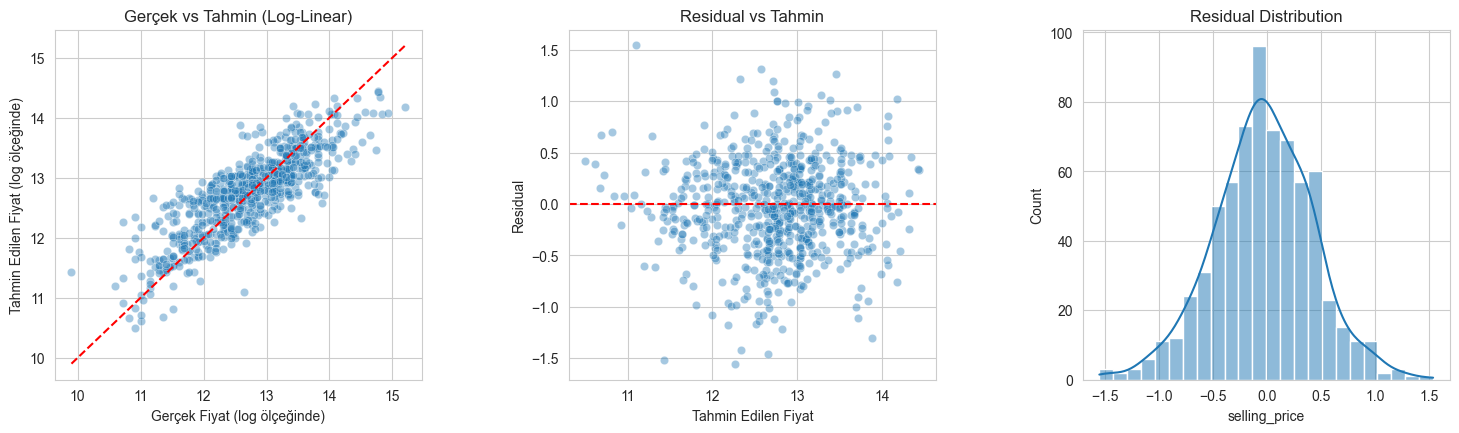

In [253]:
fig, axes = plt.subplots(1, 3, figsize=(18,5))  

sns.scatterplot(x=y_test, y=y_pred_log, alpha=0.4, ax=axes[0])
axes[0].plot([y_test.min(), y_test.max()],
             [y_test.min(), y_test.max()],
             linestyle="--", color="red")
axes[0].set_xlabel("Gerçek Fiyat (log ölçeğinde)")
axes[0].set_ylabel("Tahmin Edilen Fiyat (log ölçeğinde)")
axes[0].set_title("Gerçek vs Tahmin (Log-Linear)")

sns.scatterplot(x=y_pred_log, y=residuals, alpha=0.4, ax=axes[1])
axes[1].axhline(0, linestyle="--", color="red")
axes[1].set_xlabel("Tahmin Edilen Fiyat")
axes[1].set_ylabel("Residual")
axes[1].set_title("Residual vs Tahmin")

sns.histplot(residuals, kde=True, ax=axes[2])
axes[2].set_title("Residual Distribution")

plt.subplots_adjust(wspace=0.4, top=0.85, bottom=0.15)

### Model Performans Analizi (Log-Linear Model)

Grafikler, log dönüşümlü lineer regresyon modelimizin performansını göstermektedir:

1. **Gerçek vs Tahmin Grafiği:**  
   Tahminler, kırmızı kesikli çizgi (ideal) etrafında yoğunlaşmıştır. Bu, modelin genel olarak fiyatları doğru tahmin ettiğini göstermektedir. Yüksek ve düşük fiyatlarda küçük sapmalar gözlemlenmektedir.

2. **Residual vs Tahmin Grafiği:**  
   Residual değerleri 0 etrafında rastgele dağılmıştır ve belirgin bir desen yoktur. Bu durum, modelde heteroskedastisite sorunlarının minimal olduğunu göstermektedir.

3. **Residual Dağılımı:**  
   Histogram ve normal dağılım eğrisi, residual değerlerinin yaklaşık olarak normal dağıldığını ve merkezi 0 çevresinde yoğunlaştığını göstermektedir. Bu, model varsayımlarının büyük ölçüde sağlandığını işaret eder.

**Genel Değerlendirme:**  
Model, log dönüşümü sayesinde fiyat dağılımındaki değişkenliği iyi yakalamış ve tahminler genel olarak güvenilirdir. Küçük sapmalar olsa da model performansı güçlüdür.


In [256]:
stat, p_value = shapiro(residuals)
print("Shapiro-Wilk p-value:", p_value)

Shapiro-Wilk p-value: 0.11770749253816165


In [258]:
dw = durbin_watson(residuals)
print(f"Durbin-Watson: {dw}")

Durbin-Watson: 1.9896011283219739


In [260]:
X_bp = sm.add_constant(X_test.astype(float).values)

bp_test = het_breuschpagan(residuals, X_bp)

labels = ["LM Stat", "LM p-value", "F Stat", "F p-value"]
print(dict(zip(labels, bp_test)))

{'LM Stat': 32.744976712305316, 'LM p-value': 0.0018607413107893833, 'F Stat': 2.590355638054876, 'F p-value': 0.0016285819173339265}


In [262]:
X_train_np = sm.add_constant(X_train.astype(float).values)

vif_df = pd.DataFrame()
vif_df["Feature"] = ["const"] + list(X_train.columns)
vif_df["VIF"] = [variance_inflation_factor(X_train_np, i) for i in range(X_train_np.shape[1])]

print(vif_df.sort_values("VIF", ascending=False).head(10))

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

                       Feature         VIF
0                        const  121.147415
6                  fuel_Petrol   25.507546
3                  fuel_Diesel   25.502175
2                     car_year    1.621111
1                    km_driven    1.611192
5                     fuel_LPG    1.608533
11          owner_Second Owner    1.271678
13           owner_Third Owner    1.213572
7       seller_type_Individual    1.148982
10  owner_Fourth & Above Owner    1.091864


| Varsayım                         | Test / Yöntem            | Sonuç Değeri                          | Karar / Yorum |
|----------------------------------|--------------------------|----------------------------------------|---------------|
| Artıkların Normalliği            | Shapiro–Wilk             | p = 0.118                              | ✅ Normallik varsayımı sağlandı |
| Artıkların Otokorelasyonu        | Durbin–Watson            | DW = 1.99                              | ✅ Otokorelasyon yok |
| Değişen Varyans (Heterosked.)    | Breusch–Pagan            | p = 0.0016                             | ❌ Heteroskedastisite var |
| Çoklu Doğrusal Bağlantı           | VIF                     | fuel dummy’leri > 10                  | ⚠️ Kategorik yapıdan kaynaklı |




- **Normallik Testi (Shapiro-Wilk)**:  
  p-değeri = 0.118 → 0.05’ten büyük, hata terimleri normal dağılım varsayımı sağlamaktadır.

- **Otokorelasyon Testi (Durbin-Watson)**:  
  DW = 1.99 → 2’ye yakın, hata terimleri arasında anlamlı otokorelasyon yoktur.

- **Heteroskedastisite Testi**:  
  LM Testi p-değeri = 0.00186 → Düşük p-değerleri heteroskedastisite olabileceğini göstermekle birlikte grafikte de görüldüğü üzere heteroskedastisite etkisi minimuma indirilmiştir.

- **Multikolineerlik (VIF)**:
  → Genel olarak düşük VIF değerleri, multikolineerlik sorununu göstermemektedir.  
  → Yalnızca `const`, `fuel_Petrol` ve `fuel_Diesel` yüksek VIF değerleri ile dikkat çekmektedir. Bu değerler içinse VIF değerleri kategorileri göz önüne alındığında kabul edilebilir seviyededir.
  
### **Genel Değerlendirme:**  
Seçilmiş olan **Log-Linear model** için varsayımlar incelendiğinde varsayımların büyük çoğunluğunu sağladığı, tam sağlanmayan varsayımların ise etkisi minimuma indirilerek model güvenilirliği ve tahmin etme becerisi arttırılmıştır.

# Araç Satış Fiyatı Tahmini – Final Raporu

Bu çalışmada, ikinci el araç verileri kullanılarak satış fiyatının tahmin edilmesi amaçlanmıştır. **Lineer regresyon, log-dönüşümlü lineer regresyon, Ridge, Lasso ve Random Forest** modelleri karşılaştırılmıştır.

Veri ön işleme sürecinde kategorik değişkenler **one-hot encoding** ile modele dahil edilmiş. Satış fiyatına **logaritmik dönüşüm** uygulanarak model performansı iyileştirilmiştir. Veri setinde **eksik** gözlem bulunmamaktadır.

Sonuçlar, **log-dönüşümlü lineer regresyon** modelinin hem hata metrikleri hem de açıklanan varyans açısından en dengeli performansı sunduğunu göstermiştir. **Ridge ve Lasso** modelleri benzer sonuçlar üretirken, **Random Forest** modeli lineer modellere kıyasla daha düşük performans sergilemiştir.

Model varsayımları test edilmiş; artıkların normal dağılıma sahip olduğu ve otokorelasyon içermediği görülmüştür. **Breusch–Pagan** testi ile heteroskedastisite tespit  veri setinde yapılan dönüşümlerle etkisi azaltılmıştır.nmıştır. Çoklu bağlantı problemi ise **VIF** analizi ile kontrol edilmiştir.

Genel olarak çalışma, regresyon varsaykontrol edildiğindirildiği, yorumlanabilirliği yüksek ve metodolojik olarak tutarlı bir fiyat tahmin modeli ortaya komaktadır. Bu çalışma ile birlikte orta-üst segment araçların satış fiyatıyla ilgili tahmin yapılabilmektedir.